In [4]:
from skimage import filters
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import scipy
from scipy import ndimage
import cv2

In [7]:
# Reads in frames and bar template, TODO determine number of frames
image_folder = 'deadlift1'
bar_image = 'bar.png'
num_frames = 72
frames = np.array([io.imread(f'./{image_folder}/frame{i}.jpg') for i in range(0,num_frames)])
bar_template = np.array(io.imread(f'./{image_folder}/{bar_image}'))

In [6]:
#Removes opacity channel from template so both images are rgb
bar_template = bar_template[:,:,0:3]

In [1]:
def circularNeighbors(img, x, y, radius):
    neighborhood = []
    for i in range(len(img)):
        for j in range(len(img[0])):
            # if pixel in circle then add it
            if ((x-j)**2 + (y-i)**2)**.5 < radius:
                # NOTE: i, j flipped like before
                neighborhood.append([j, i, *img[i, j]])
    return np.array(neighborhood)

In [2]:
def colorHistogram(X, bins, x, y, h):
    # X -> [xi, yi, R, G, B]
    hist = np.zeros((bins, bins, bins))

    # kernel
    def Epanechnikov(x0, y0, xi, yi):
        r = (np.sqrt((x0-xi)**2 + (y0-yi)**2)/h)**2
        return 1-r if r < 1 else 0

    # add the weighted value to the correct bin for each pixel
    for xi, yi, R, G, B in X:
        hist[R // int(256/bins), G // int(256/bins), B // int(256/bins)] += Epanechnikov(x, y, xi, yi)
    

    return hist

In [3]:
def meanshiftWeights(X, q_model, p_test, bins):
    w = []
    for xi, yi, R, G, B in X:
        if q_model[R // int(256/bins), G // int(256/bins), B // int(256/bins)] == 0:
            w.append(1)
        else:
            w.append((q_model[R // int(256/bins), G // int(256/bins), B // int(256/bins)] / p_test[R // int(256/bins), G // int(256/bins), B // int(256/bins)])**.5)
    return np.array(w)

In [32]:
def createVideoFromFrames(frames,out_file,fps=30):
    out = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frames[0].shape[1], frames[0].shape[0]))
    for i in range(len(frames)):
        out.write(cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR))
    out.release()

In [40]:
#1920 x 1440 images are simply to large so we blur and downsample both the image and the template to find the correct area and then do a search over that specific area
#radius of filter matches how many times smaller the image is reduced
"""
    blurs the given @im using a guassian filter with @sigma and downscales by @scale(ie 32 means 32 times smaller on both width and height)
"""

def blur_and_downsample(im,scale=16,sigma=16):
    
    blurred_im = filters.gaussian(im, sigma=sigma,truncate=sigma/scale,channel_axis=-1)
    downscaled_im = blurred_im[::scale,::scale,::]
    return downscaled_im

In [21]:
n = circularNeighbors(frames[0], 1100, 690, 105)
q = colorHistogram(n, 16, 1100, 690, 105)
np.count_nonzero(q)

141

In [22]:
y = [1100, 690]
vals = []
vals.append(y)
for i in range(25):
    # img2 neighborhood
    n2 = circularNeighbors(frames[1], y[0], y[1], 105)
    p = colorHistogram(n2, 16, y[0], y[1], 105)
    print(np.count_nonzero(p))
    W = meanshiftWeights(n2, q, p, 16)
    # x values
    X1 = np.dot(n2[:,0], W)/np.sum(W)
    # y values
    Y1 = np.dot(n2[:,1], W)/np.sum(W)
    y = [X1, Y1]
    vals.append(y)
    print(y)

140
[1100.073653270852, 690.2447780151975]
139
[1100.1445579508224, 690.3724845685813]
138
[1100.2176285041662, 690.4315343925317]
139
[1100.2993736612848, 690.4656682468119]
139
[1100.3386308142253, 690.4628617946595]
139
[1100.363071018654, 690.4680666023634]
139
[1100.3845616493077, 690.4589558735851]
139
[1100.4057721026616, 690.4570252427634]
139
[1100.4178229078736, 690.4609079162555]
139
[1100.424038691326, 690.4623394092199]
139
[1100.4251738754112, 690.4626537052806]
139
[1100.4265956596155, 690.4599073052148]
139
[1100.4288803240968, 690.455734484431]
139
[1100.4351239389018, 690.4493537051411]
139
[1100.444197038491, 690.4413901339816]
139
[1100.4460523816697, 690.4428807499352]
139
[1100.4451470435642, 690.441935925625]
139
[1100.4456126080304, 690.4425161953823]
139
[1100.4453683700988, 690.4421667054033]
139
[1100.4455003371816, 690.4423746473019]
139
[1100.4454277990703, 690.4422519225964]
139
[1100.4454683322483, 690.4423239712935]
139
[1100.4454454445201, 690.442281825

In [50]:
tracked_frames = []
# initial values
y = [1100, 690]
n = circularNeighbors(frames[0], y[0], y[1], 105)
q = colorHistogram(n, 16, y[0], y[1], 105)
np.count_nonzero(q)
for i, frame in enumerate(frames):
    for j in range(25):
        # img2 neighborhood
        n2 = circularNeighbors(frame, y[0], y[1], 105)
        p = colorHistogram(n2, 16, y[0], y[1], 105)
        W = meanshiftWeights(n2, q, p, 16)
        # x values
        X1 = np.dot(n2[:,0], W)/np.sum(W)
        # y values
        Y1 = np.dot(n2[:,1], W)/np.sum(W)
        y = [X1, Y1]
    print(i, y)
    tracked = cv2.circle(frame.copy(),(int(y[1]), int(y[0])), 105, (255,0,0), 2)
    tracked_frames.append(tracked)
    
    n = circularNeighbors(frame, y[0], y[1], 105)
    q = colorHistogram(n, 16, y[0], y[1], 105)
    

0 [1100.0, 690.0]
1 [1100.4454510141952, 690.4422920911721]
2 [1100.2838912694897, 690.4536402425882]
3 [1101.969387865924, 689.9473414093771]
4 [1100.3667492482, 689.7925385230592]
5 [1100.2984106620913, 690.302721688606]
6 [1101.946198150702, 690.3344436939695]
7 [1103.5788998784856, 689.7395337230894]
8 [1103.0856265840252, 689.78173411163]
9 [1103.6066813482287, 690.0476317171529]
10 [1103.2411071408817, 689.5280196409096]
11 [1102.350946151268, 690.2183221307383]
12 [1105.0881638017934, 690.0310853090485]
13 [1099.672704348163, 690.5180316881306]
14 [1098.1112210859555, 690.9213050069027]
15 [1099.7738135917496, 691.1267164058155]
16 [1098.233650309088, 691.4614558350684]
17 [1098.2798597451754, 691.5549697100985]
18 [1097.278051828076, 691.4743672396236]
19 [1097.4918024182678, 691.2986268661798]
20 [1097.3881178021231, 691.4486759614085]
21 [1097.6236983311876, 691.3676532280888]
22 [1099.457240438424, 691.4023885123165]
23 [1098.2965655355492, 691.4735184320966]
24 [1097.735926

In [51]:
createVideoFromFrames(tracked_frames, 'mean_shift_25iter.mp4', 5)

In [47]:
io.imshow(cv2.circle(blur_and_downsample(frames[0]),(int(690/16), int(1100/16)), 6, (255,0,0), 2))

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


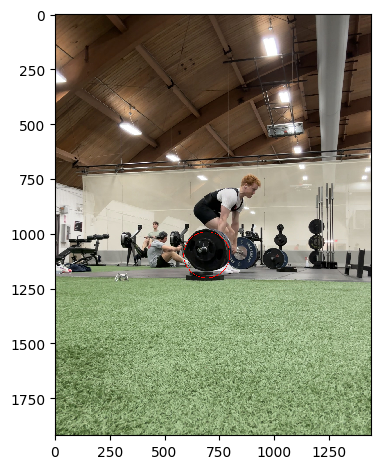

In [29]:
io.imshow(cv2.circle(frames[23].copy(),(int(691.8979722860782), int(1098.626014285168)), 105, (255,0,0), 2))

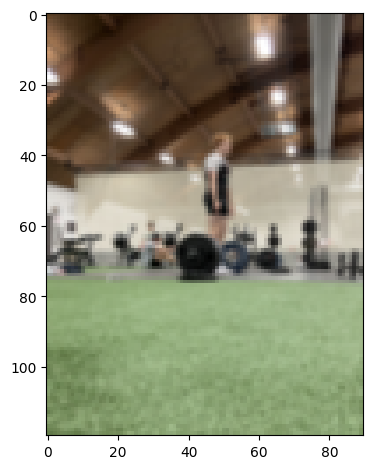

In [43]:
io.imshow(blur_and_downsample(frames[0]))